In [16]:
import geopandas as gpd
df = gpd.read_file('/data/acker/ALA/paper2/all_variables.shp')
df = df.rename(columns={'monitor__1':'monitor_coverage_pct', 'classifica':'classification', 'Design Val':'Design Value', 'monitor_co':'monitor_count',
                        'fire_regio':'fire_region', 'mountain_r':'mountain_region', 'desert_reg':'desert_region', 'urban_cate':'urban_category'})
#upload shapefile of U.S. counties
counties = gpd.read_file('/data/acker/shapefiles/cb_2020_us_county_500k.shp')
# List of state abbreviations for CONUS, Alaska (AK), and Hawaii (HI)
states_to_include = [
    'AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 'DC',
    'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS',
    'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK',
    'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV',
    'WI', 'WY'
]

# Filter counties to only include rows where STUSPS is in the specified list
counties_conus = counties[counties['STUSPS'].isin(states_to_include)]

# Display the filtered counties
counties_conus = counties_conus.drop(["COUNTYNS", 'NAMELSAD', 'LSAD', 'ALAND', 'AWATER', 'AFFGEOID'], axis=1)
counties_conus = counties_conus.to_crs(df.crs)
df = df.drop(columns='geometry')


# Merge with both GEOID and geometry
new = df.merge(counties_conus[['GEOID', 'geometry']], on='GEOID', how='inner')

# Recast as GeoDataFrame
ranked_correct = gpd.GeoDataFrame(new, geometry='geometry', crs=counties_conus.crs)
df = ranked_correct
df

,GEOID,PM25_90th,Design Value,classification,diff,abs_diff,monitor_count,cdv_bin,monitor_coverage_pct,dist_km,size,fire_region,mountain_region,desert_region,urban_category,geometry
0,02090,14.333333,12.1,TP,2.233333,2.233333,3,>10,0.008092,85.118385,large,Fire,Mountain,Non-Desert,Non-Urban (<50%),"POLYGON ((-148.66326 64.59079, -148.64821 64.5..."
1,06063,14.200000,14.0,TP,0.200000,0.200000,1,>10,0.013591,60.606568,large,Fire,Mountain,Non-Desert,Non-Urban (<50%),"POLYGON ((-121.49703 40.43702, -121.49487 40.4..."
2,06107,12.933334,15.7,TP,-2.766666,2.766666,1,>10,0.007784,100.833209,large,Fire,Mountain,Non-Desert,Non-Urban (<50%),"POLYGON ((-119.56647 36.49434, -119.56366 36.4..."
3,06023,12.633334,6.9,FP,5.733334,5.733334,1,<7,0.009894,28.714886,large,Fire,Mountain,Non-Desert,Non-Urban (<50%),"POLYGON ((-124.4086 40.4432, -124.39664 40.462..."
4,06029,12.599999,16.2,TP,-3.600001,3.600001,5,>10,0.023405,82.031806,large,Fire,Mountain,Non-Desert,Non-Urban (<50%),"POLYGON ((-120.19437 35.78936, -120.00308 35.7..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
531,02020,4.133333,5.1,TN,-0.966667,0.966667,1,<7,0.020235,66.108117,small,Non-Fire,Mountain,Non-Desert,Non-Urban (<50%),"MULTIPOLYGON (((-150.07348 61.15834, -150.0691..."
532,02110,3.900000,4.6,TN,-0.700000,0.700000,1,<7,0.018594,73.544905,large,Non-Fire,Mountain,Non-Desert,Non-Urban (<50%),"MULTIPOLYGON (((-134.66932 58.33327, -134.6675..."
533,15001,3.633333,4.4,TN,-0.766667,0.766667,5,<7,0.054825,81.864071,large,Fire,Non-Mountain,Non-Desert,Non-Urban (<50%),"POLYGON ((-156.06147 19.72813, -156.06076 19.7..."
534,15009,3.556667,4.0,TN,-0.443333,0.443333,1,<7,0.035920,78.820617,small,Fire,Non-Mountain,Non-Desert,Non-Urban (<50%),"MULTIPOLYGON (((-156.69742 20.91637, -156.6957..."


In [17]:
disagreement = df[(df['classification'] == 'FP') | (df['classification'] == 'FN')]
agreement = df[(df['classification'] == 'TP') | (df['classification'] == 'TN')]

In [18]:
import geopandas as gpd


# Initialize
variables = []
delta_values = []

# Fire Region
delta_fire = abs(
    disagreement[disagreement['fire_region'] == 'Fire']['abs_diff'].mean() -
    disagreement[disagreement['fire_region'] == 'Non-Fire']['abs_diff'].mean()
)
variables.append('fire_region')
delta_values.append(delta_fire)

# Mountain Region
delta_mountain = abs(
    disagreement[disagreement['mountain_region'] == 'Mountain']['abs_diff'].mean() -
    disagreement[disagreement['mountain_region'] == 'Non-Mountain']['abs_diff'].mean()
)
variables.append('mountain_region')
delta_values.append(delta_mountain)

# Desert Region
delta_desert = abs(
    disagreement[disagreement['desert_region'] == 'Desert']['abs_diff'].mean() -
    disagreement[disagreement['desert_region'] == 'Non-Desert']['abs_diff'].mean()
)
variables.append('desert_region')
delta_values.append(delta_desert)

# Urban Category
delta_urban = abs(
    disagreement[disagreement['urban_category'] == 'Non-Urban (<50%)']['abs_diff'].mean() -
    disagreement[disagreement['urban_category'] == 'Urban (≥50%)']['abs_diff'].mean()
)
variables.append('urban_category')
delta_values.append(delta_urban)

delta_size = abs(
    disagreement[disagreement['size'] == 'large']['abs_diff'].mean() -
    disagreement[disagreement['size'] == 'small']['abs_diff'].mean()
)
variables.append('size')
delta_values.append(delta_size)

# Normalize weights
total_delta = sum(delta_values)
weights_A = {var: delta / total_delta for var, delta in zip(variables, delta_values)}

print("Option A: Weights (proportional to Δabs_diff)")
for var, weight in weights_A.items():
    print(f"{var}: {weight:.3f}")


Option A: Weights (proportional to Δabs_diff)
fire_region: 0.225
mountain_region: 0.060
desert_region: 0.274
urban_category: 0.136
size: 0.305


In [19]:
# Initialize
weighted_deltas = []

for var, delta in zip(variables, delta_values):
    if var == 'fire_region':
        n_high_risk = disagreement[disagreement['fire_region'] == 'Fire'].shape[0]
    elif var == 'mountain_region':
        n_high_risk = disagreement[disagreement['mountain_region'] == 'Mountain'].shape[0]
    elif var == 'desert_region':
        n_high_risk = disagreement[disagreement['desert_region'] == 'Desert'].shape[0]
    elif var == 'urban_category':
        n_high_risk = disagreement[disagreement['urban_category'] == 'Non-Urban (<50%)'].shape[0]
    elif var == 'size':
        n_high_risk = disagreement[disagreement['size'] == 'large'].shape[0]
    
    weighted_delta = delta * n_high_risk
    weighted_deltas.append(weighted_delta)

# Normalize weights
total_weighted_delta = sum(weighted_deltas)
weights_C = {var: wd / total_weighted_delta for var, wd in zip(variables, weighted_deltas)}

print("\nOption C: Weights (Δabs_diff × prevalence)")
for var, weight in weights_C.items():
    print(f"{var}: {weight:.3f}")



Option C: Weights (Δabs_diff × prevalence)
fire_region: 0.262
mountain_region: 0.090
desert_region: 0.043
urban_category: 0.405
size: 0.201


In [20]:
# --- Calculate risk scores for monitored counties using Option C weights ---

# Apply Option C weights (assumes weights_A is already calculated)
risk_scores = []

for idx, row in df.iterrows():
    score = 0
    # Apply weights for each variable
    if row['fire_region'] == 'Fire':
        score += weights_A['fire_region']
    if row['mountain_region'] == 'Mountain':
        score += weights_A['mountain_region']
    if row['desert_region'] == 'Desert':
        score += weights_A['desert_region']
    if row['urban_category'] == 'Non-Urban (<50%)':
        score += weights_A['urban_category']
    if row['size'] == 'large':
        score += weights_A['size']
    risk_scores.append(score)

# Add risk scores to the dataframe
df['risk_score_A'] = risk_scores

# Normalize risk scores to 0-1 scale for easy comparison
df['risk_score_A_norm'] = (df['risk_score_A'] - df['risk_score_A'].min()) / (df['risk_score_A'].max() - df['risk_score_A'].min())

# Save output (optional)
# df.to_file('/data/acker/ALA/paper2/monitored_counties_with_risk.shp')

print(df[['GEOID', 'risk_score_A', 'risk_score_A_norm']].head(20))


    GEOID  risk_score_A  risk_score_A_norm
0   02090      0.725705           0.725705
1   06063      0.725705           0.725705
2   06107      0.725705           0.725705
3   06023      0.725705           0.725705
4   06029      0.725705           0.725705
5   06037      0.666033           0.666033
6   06031      0.195277           0.195277
7   06059      0.000000           0.000000
8   06019      0.725705           0.725705
9   06093      0.725705           0.725705
10  06047      0.500513           0.500513
11  06073      0.940328           0.940328
12  06025      0.940328           0.940328
13  06065      0.940328           0.940328
14  18097      0.000000           0.000000
15  48201      0.000000           0.000000
16  28047      0.360797           0.360797
17  41039      0.725705           0.725705
18  06039      0.725705           0.725705
19  26163      0.000000           0.000000


In [21]:
# --- Calculate risk scores for monitored counties using Option C weights ---

# Apply Option C weights (assumes weights_C is already calculated)
risk_scores = []

for idx, row in df.iterrows():
    score = 0
    # Apply weights for each variable
    if row['fire_region'] == 'Fire':
        score += weights_C['fire_region']
    if row['mountain_region'] == 'Mountain':
        score += weights_C['mountain_region']
    if row['desert_region'] == 'Desert':
        score += weights_C['desert_region']
    if row['urban_category'] == 'Non-Urban (<50%)':
        score += weights_C['urban_category']
    if row['size'] == 'large':
        score += weights_C['size']
    risk_scores.append(score)

# Add risk scores to the dataframe
df['risk_score_C'] = risk_scores

# Normalize risk scores to 0-1 scale for easy comparison
df['risk_score_C_norm'] = (df['risk_score_C'] - df['risk_score_C'].min()) / (df['risk_score_C'].max() - df['risk_score_C'].min())

# Save output (optional)
# df.to_file('/data/acker/ALA/paper2/monitored_counties_with_risk.shp')

print(df[['GEOID', 'risk_score_C', 'risk_score_C_norm']].head(20))


    GEOID  risk_score_C  risk_score_C_norm
0   02090      0.957491           0.957491
1   06063      0.957491           0.957491
2   06107      0.957491           0.957491
3   06023      0.957491           0.957491
4   06029      0.957491           0.957491
5   06037      0.867327           0.867327
6   06031      0.494709           0.494709
7   06059      0.000000           0.000000
8   06019      0.957491           0.957491
9   06093      0.957491           0.957491
10  06047      0.695750           0.695750
11  06073      0.909836           0.909836
12  06025      0.909836           0.909836
13  06065      0.909836           0.909836
14  18097      0.000000           0.000000
15  48201      0.000000           0.000000
16  28047      0.666287           0.666287
17  41039      0.957491           0.957491
18  06039      0.957491           0.957491
19  26163      0.000000           0.000000


In [7]:
df.columns

Index(['GEOID', 'PM25_90th', 'Design Value', 'classification', 'diff',
       'abs_diff', 'monitor_count', 'cdv_bin', 'monitor_coverage_pct',
       'dist_km', 'size', 'fire_region', 'mountain_region', 'desert_region',
       'urban_category', 'geometry', 'risk_score_A', 'risk_score_A_norm',
       'risk_score_C', 'risk_score_C_norm'],
      dtype='object')

In [22]:
# Extract the North Slope row from `counties_conus`
north_slope = counties_conus[counties_conus['GEOID'] == '02185'].copy()

# Set the `PM25_90th` column to None (or NaN) so it appears gray on the plot
north_slope['PM25_90th'] = None


/tmp/ipykernel_7706/2287605480.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


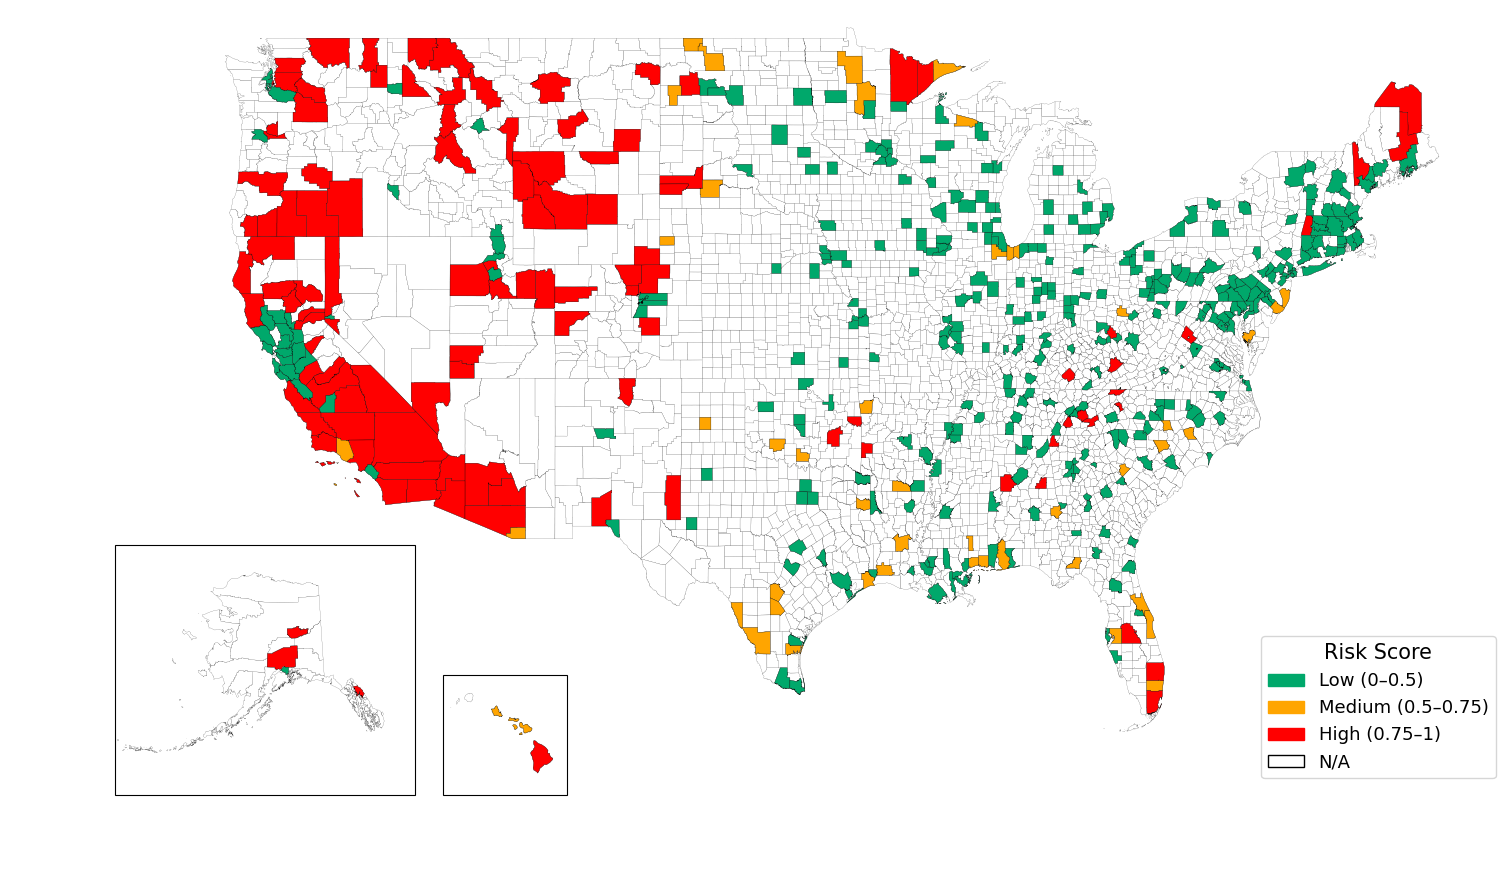

In [9]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd
import matplotlib.patches as mpatches
import pandas as pd

# --- Load and prepare data ---
gdf_epa = df.to_crs("EPSG:4326")  # Make sure CRS is in lat/lon

# Use normalized risk scores
data_column = 'risk_score_C'  # Change this if you saved under a different column name

# Define color mapping based on thresholds
def assign_risk_color(value):
    if pd.isna(value):
        return 'white'  # For missing values
    elif value <= 0.5:
        return '#00A86B'  # Low risk (green)
    elif value <= 0.75:
        return '#FFA500'  # Medium risk (orange)
    else:
        return '#FF0000'  # High risk (red)

# Apply color mapping
gdf_epa['color'] = gdf_epa[data_column].apply(assign_risk_color)

# --- Start plotting ---
fig = plt.figure(figsize=(15, 10))

# Main map (CONUS)
ax_conus = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax_conus.set_extent([-135, -65, 20, 50], crs=ccrs.PlateCarree())
ax_conus.set_frame_on(False)

# Alaska inset
alaska_projection = ccrs.AlbersEqualArea(central_longitude=-150, central_latitude=60)
ax_alaska = fig.add_axes([0.07, 0.14, 0.22, 0.25], projection=alaska_projection)
ax_alaska.set_extent([-180, -126, 50, 72], crs=ccrs.PlateCarree())

# Hawaii inset
ax_hawaii = fig.add_axes([0.28, 0.14, 0.12, 0.12], projection=ccrs.PlateCarree())
ax_hawaii.set_extent([-161, -154, 18, 23], crs=ccrs.PlateCarree())

# Plot CONUS base map
counties_conus.plot(
    color='white', linewidth=0.1, edgecolor='black', ax=ax_conus
)

# Plot EPA counties on top
gdf_epa.plot(
    color=gdf_epa['color'], linewidth=0.2, edgecolor='black', ax=ax_conus
)

# Plot Alaska and Hawaii base maps
counties_conus.plot(
    color='white', linewidth=0.1, edgecolor='black', ax=ax_alaska, transform=ccrs.PlateCarree()
)
counties_conus.plot(
    color='white', linewidth=0.1, edgecolor='black', ax=ax_hawaii
)

# Plot EPA counties for Alaska and Hawaii on top
gdf_epa.plot(
    color=gdf_epa['color'], linewidth=0.2, edgecolor='black', ax=ax_alaska, transform=ccrs.PlateCarree()
)
gdf_epa.plot(
    color=gdf_epa['color'], linewidth=0.2, edgecolor='black', ax=ax_hawaii
)


# --- Create custom legend ---
low_patch = mpatches.Patch(color='#00A86B', label='Low (0–0.5)')
medium_patch = mpatches.Patch(color='#FFA500', label='Medium (0.5–0.75)')
high_patch = mpatches.Patch(color='#FF0000', label='High (0.75–1)')
na_patch = mpatches.Patch(facecolor="white", edgecolor="black", label="N/A")

plt.legend(
    handles=[low_patch, medium_patch, high_patch, na_patch],
    bbox_to_anchor=(6.5, 1.4), loc='upper left',
    title="Risk Score",
    fontsize=13,
    title_fontsize=15
)

# --- Title and layout ---
plt.rcParams["font.family"] = "serif"
#fig.suptitle("County Risk Assessment (Weighted Index)", fontsize=18, y=0.92)

plt.tight_layout()
plt.show()


/tmp/ipykernel_7706/271812278.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


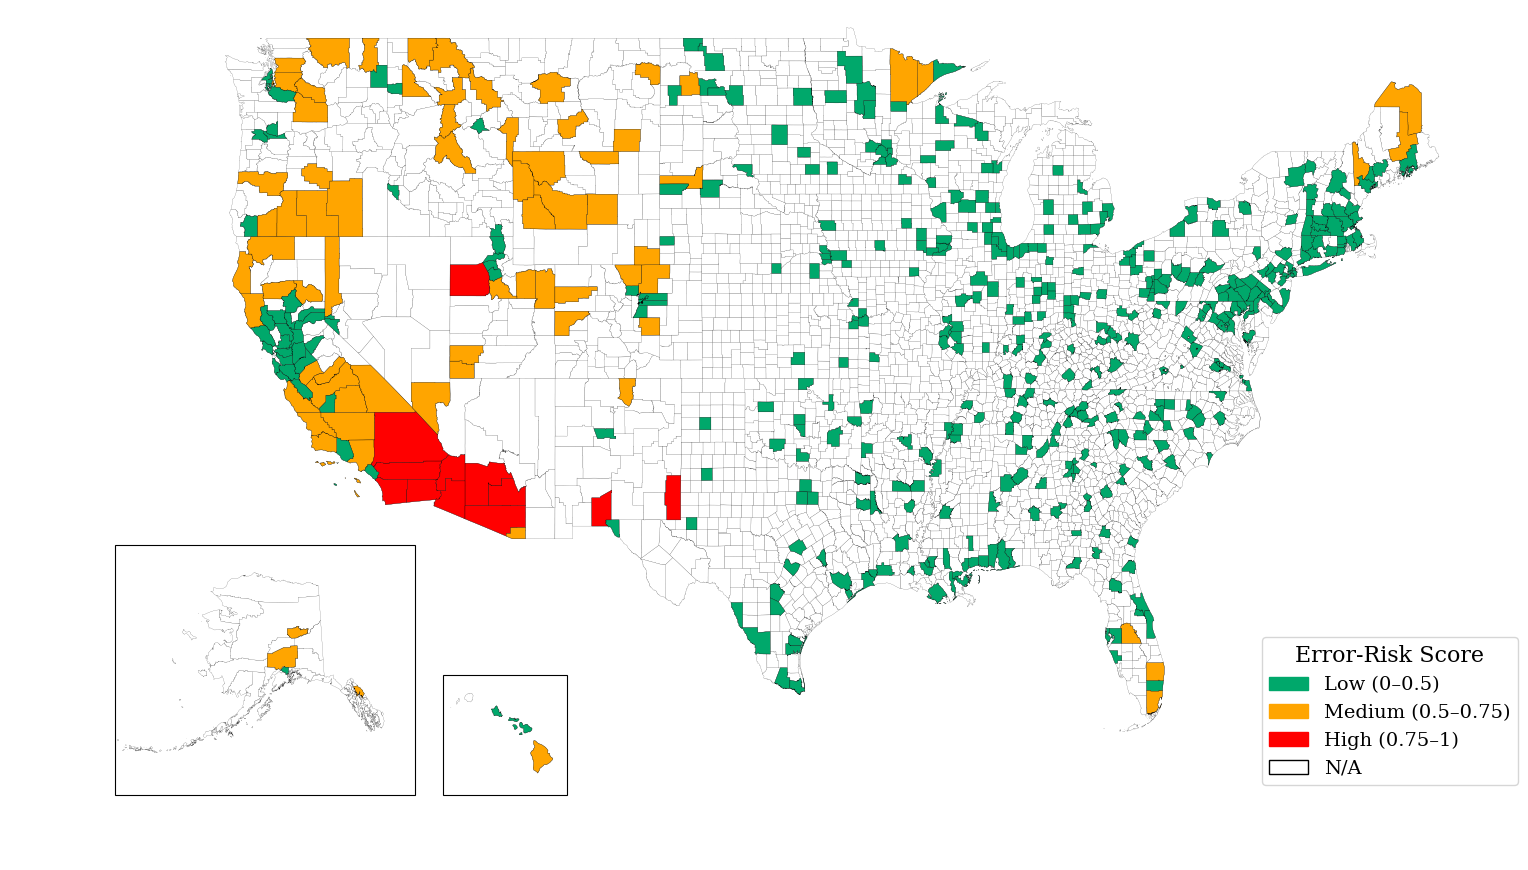

In [23]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd
import matplotlib.patches as mpatches
import pandas as pd

# --- Load and prepare data ---
gdf_epa = df.to_crs("EPSG:4326")  # Make sure CRS is in lat/lon

# Use normalized risk scores
data_column = 'risk_score_A'  # Change this if you saved under a different column name

# Define color mapping based on thresholds
def assign_risk_color(value):
    if pd.isna(value):
        return 'white'  # For missing values
    elif value <= 0.5:
        return '#00A86B'  # Low risk (green)
    elif value <= 0.75:
        return '#FFA500'  # Medium risk (orange)
    else:
        return '#FF0000'  # High risk (red)

# Apply color mapping
gdf_epa['color'] = gdf_epa[data_column].apply(assign_risk_color)

# --- Start plotting ---
fig = plt.figure(figsize=(15, 10))

# Main map (CONUS)
ax_conus = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax_conus.set_extent([-135, -65, 20, 50], crs=ccrs.PlateCarree())
ax_conus.set_frame_on(False)

# Alaska inset
alaska_projection = ccrs.AlbersEqualArea(central_longitude=-150, central_latitude=60)
ax_alaska = fig.add_axes([0.07, 0.14, 0.22, 0.25], projection=alaska_projection)
ax_alaska.set_extent([-180, -126, 50, 72], crs=ccrs.PlateCarree())

# Hawaii inset
ax_hawaii = fig.add_axes([0.28, 0.14, 0.12, 0.12], projection=ccrs.PlateCarree())
ax_hawaii.set_extent([-161, -154, 18, 23], crs=ccrs.PlateCarree())

# Plot CONUS base map
counties_conus.plot(
    color='white', linewidth=0.1, edgecolor='black', ax=ax_conus
)

# Plot EPA counties on top
gdf_epa.plot(
    color=gdf_epa['color'], linewidth=0.2, edgecolor='black', ax=ax_conus
)

# Plot Alaska and Hawaii base maps
counties_conus.plot(
    color='white', linewidth=0.1, edgecolor='black', ax=ax_alaska, transform=ccrs.PlateCarree()
)
counties_conus.plot(
    color='white', linewidth=0.1, edgecolor='black', ax=ax_hawaii
)

# Plot EPA counties for Alaska and Hawaii on top
gdf_epa.plot(
    color=gdf_epa['color'], linewidth=0.2, edgecolor='black', ax=ax_alaska, transform=ccrs.PlateCarree()
)
gdf_epa.plot(
    color=gdf_epa['color'], linewidth=0.2, edgecolor='black', ax=ax_hawaii
)


# --- Create custom legend ---
low_patch = mpatches.Patch(color='#00A86B', label='Low (0–0.5)')
medium_patch = mpatches.Patch(color='#FFA500', label='Medium (0.5–0.75)')
high_patch = mpatches.Patch(color='#FF0000', label='High (0.75–1)')
na_patch = mpatches.Patch(facecolor="white", edgecolor="black", label="N/A")

plt.legend(
    handles=[low_patch, medium_patch, high_patch, na_patch],
    bbox_to_anchor=(6.5, 1.4), loc='upper left',
    title="Error-Risk Score",
    fontsize=14,
    title_fontsize=16
)

# --- Title and layout ---
plt.rcParams["font.family"] = "serif"
#fig.suptitle("a) Monitored Counties", fontsize=24, y=0.92)
plt.tight_layout()
plt.show()


In [24]:
unmon_df = gpd.read_file('/data/acker/ALA/paper2/all_variables_unmonitored.shp')
unmon_df = unmon_df.rename(columns={'fire_regio':'fire_region', 'mountain_r':'mountain_region', 'desert_reg':'desert_region', 'urban_cate':'urban_category'})
unmon_df = unmon_df.drop(columns='geometry')


# Merge with both GEOID and geometry
new = unmon_df.merge(counties_conus[['GEOID', 'geometry']], on='GEOID', how='inner')

# Recast as GeoDataFrame
ranked_correct = gpd.GeoDataFrame(new, geometry='geometry', crs=counties_conus.crs)
unmon_df = ranked_correct

In [25]:
# --- Calculate risk scores for monitored counties using Option C weights ---

# Apply Option C weights (assumes weights_A is already calculated)
risk_scores = []

for idx, row in unmon_df.iterrows():
    score = 0
    # Apply weights for each variable
    if row['fire_region'] == 'Fire':
        score += weights_A['fire_region']
    if row['mountain_region'] == 'Mountain':
        score += weights_A['mountain_region']
    if row['desert_region'] == 'Desert':
        score += weights_A['desert_region']
    if row['urban_category'] == 'Non-Urban (<50%)':
        score += weights_A['urban_category']
    if row['size'] == 'large':
        score += weights_A['size']
    risk_scores.append(score)

# Add risk scores to the dataframe
unmon_df['risk_score_A'] = risk_scores

# Normalize risk scores to 0-1 scale for easy comparison
unmon_df['risk_score_A_norm'] = (unmon_df['risk_score_A'] - unmon_df['risk_score_A'].min()) / (unmon_df['risk_score_A'].max() - unmon_df['risk_score_A'].min())

# Save output (optional)
# unmon_df.to_file('/data/acker/ALA/paper2/monitored_counties_with_risk.shp')

print(unmon_df[['GEOID', 'risk_score_A', 'risk_score_A_norm']].head(20))


    GEOID  risk_score_A  risk_score_A_norm
0   01001      0.195277           0.195277
1   01005      0.360797           0.360797
2   01007      0.420469           0.420469
3   01009      0.195277           0.195277
4   01011      0.135605           0.135605
5   01013      0.135605           0.135605
6   01015      0.420469           0.420469
7   01017      0.360797           0.360797
8   01019      0.420469           0.420469
9   01021      0.420469           0.420469
10  01023      0.135605           0.135605
11  01025      0.135605           0.135605
12  01029      0.420469           0.420469
13  01031      0.135605           0.135605
14  01033      0.195277           0.195277
15  01035      0.135605           0.135605
16  01037      0.195277           0.195277
17  01039      0.360797           0.360797
18  01041      0.135605           0.135605
19  01043      0.195277           0.195277


In [26]:
# --- Calculate risk scores for monitored counties using Option C weights ---

# Apply Option C weights (assumes weights_C is already calculated)
risk_scores = []

for idx, row in unmon_df.iterrows():
    score = 0
    # Apply weights for each variable
    if row['fire_region'] == 'Fire':
        score += weights_C['fire_region']
    if row['mountain_region'] == 'Mountain':
        score += weights_C['mountain_region']
    if row['desert_region'] == 'Desert':
        score += weights_C['desert_region']
    if row['urban_category'] == 'Non-Urban (<50%)':
        score += weights_C['urban_category']
    if row['size'] == 'large':
        score += weights_C['size']
    risk_scores.append(score)

# Add risk scores to the dataframe
unmon_df['risk_score_C'] = risk_scores

# Normalize risk scores to 0-1 scale for easy comparison
unmon_df['risk_score_C_norm'] = (unmon_df['risk_score_C'] - unmon_df['risk_score_C'].min()) / (unmon_df['risk_score_C'].max() - unmon_df['risk_score_C'].min())

# Save output (optional)
# unmon_df.to_file('/data/acker/ALA/paper2/monitored_counties_with_risk.shp')

print(unmon_df[['GEOID', 'risk_score_C', 'risk_score_C_norm']].head(20))


    GEOID  risk_score_C  risk_score_C_norm
0   01001      0.494709           0.494709
1   01005      0.666287           0.666287
2   01007      0.756451           0.756451
3   01009      0.494709           0.494709
4   01011      0.404545           0.404545
5   01013      0.404545           0.404545
6   01015      0.756451           0.756451
7   01017      0.666287           0.666287
8   01019      0.756451           0.756451
9   01021      0.756451           0.756451
10  01023      0.404545           0.404545
11  01025      0.404545           0.404545
12  01029      0.756451           0.756451
13  01031      0.404545           0.404545
14  01033      0.494709           0.494709
15  01035      0.404545           0.404545
16  01037      0.494709           0.494709
17  01039      0.666287           0.666287
18  01041      0.404545           0.404545
19  01043      0.494709           0.494709


/tmp/ipykernel_7706/2222334781.py:111: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


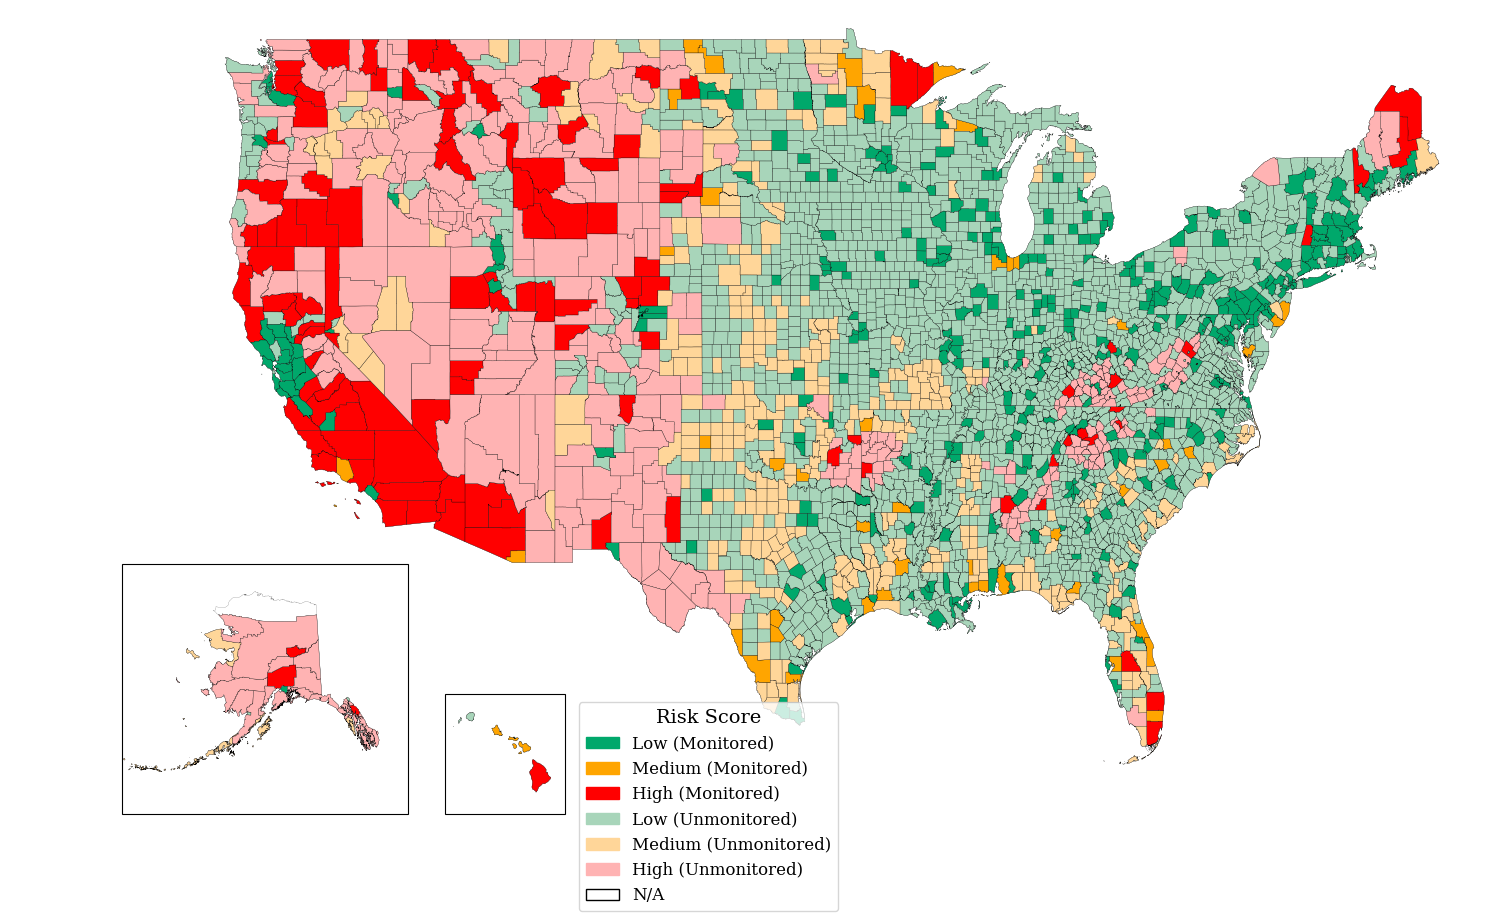

In [14]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd
import matplotlib.patches as mpatches
import pandas as pd

# --- Prepare monitored data ---
gdf_epa = gdf_epa.to_crs("EPSG:4326")  # Monitored counties CRS
data_column_mon = 'risk_score_C'

# Define color mapping for monitored counties
def assign_risk_color_mon(value):
    if pd.isna(value):
        return 'white'
    elif value <= 0.5:
        return '#00A86B'  # Dark green for low risk
    elif value <= 0.75:
        return '#FFA500'  # Orange for medium risk
    else:
        return '#FF0000'  # Red for high risk

gdf_epa['color'] = gdf_epa[data_column_mon].apply(assign_risk_color_mon)

# --- Prepare unmonitored data ---
unmon_df = unmon_df.to_crs("EPSG:4326")
data_column_unmon = 'risk_score_C'

# Define muted color mapping for unmonitored counties
def assign_risk_color_unmon(value):
    if pd.isna(value):
        return 'white'
    elif value <= 0.5:
        return '#A8D5BA'  # Muted green for low risk
    elif value <= 0.75:
        return '#FFD699'  # Muted orange for medium risk
    else:
        return '#FFB3B3'  # Muted red for high risk

unmon_df['color'] = unmon_df[data_column_unmon].apply(assign_risk_color_unmon)

# --- Start plotting ---
fig = plt.figure(figsize=(15, 10))

# Main map (CONUS)
ax_conus = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax_conus.set_extent([-135, -65, 20, 50], crs=ccrs.PlateCarree())
ax_conus.set_frame_on(False)

# Alaska inset
alaska_projection = ccrs.AlbersEqualArea(central_longitude=-150, central_latitude=60)
ax_alaska = fig.add_axes([0.07, 0.14, 0.22, 0.25], projection=alaska_projection)
ax_alaska.set_extent([-180, -126, 50, 72], crs=ccrs.PlateCarree())

# Hawaii inset
ax_hawaii = fig.add_axes([0.28, 0.14, 0.12, 0.12], projection=ccrs.PlateCarree())
ax_hawaii.set_extent([-161, -154, 18, 23], crs=ccrs.PlateCarree())

# --- Plot base maps ---
counties_conus.plot(
    color='white', linewidth=0.1, edgecolor='black', ax=ax_conus
)
counties_conus.plot(
    color='white', linewidth=0.1, edgecolor='black', ax=ax_alaska, transform=ccrs.PlateCarree()
)
counties_conus.plot(
    color='white', linewidth=0.1, edgecolor='black', ax=ax_hawaii
)

# --- Plot monitored counties ---
gdf_epa.plot(
    color=gdf_epa['color'], linewidth=0.2, edgecolor='black', ax=ax_conus
)
gdf_epa.plot(
    color=gdf_epa['color'], linewidth=0.2, edgecolor='black', ax=ax_alaska, transform=ccrs.PlateCarree()
)
gdf_epa.plot(
    color=gdf_epa['color'], linewidth=0.2, edgecolor='black', ax=ax_hawaii
)

# --- Plot unmonitored counties ---
unmon_df.plot(
    color=unmon_df['color'], linewidth=0.2, edgecolor='black', ax=ax_conus
)
unmon_df.plot(
    color=unmon_df['color'], linewidth=0.2, edgecolor='black', ax=ax_alaska, transform=ccrs.PlateCarree()
)
unmon_df.plot(
    color=unmon_df['color'], linewidth=0.2, edgecolor='black', ax=ax_hawaii
)

# --- Custom Legend ---
mon_low = mpatches.Patch(color='#00A86B', label='Low (Monitored)')
mon_med = mpatches.Patch(color='#FFA500', label='Medium (Monitored)')
mon_high = mpatches.Patch(color='#FF0000', label='High (Monitored)')

unmon_low = mpatches.Patch(color='#A8D5BA', label='Low (Unmonitored)')
unmon_med = mpatches.Patch(color='#FFD699', label='Medium (Unmonitored)')
unmon_high = mpatches.Patch(color='#FFB3B3', label='High (Unmonitored)')

na_patch = mpatches.Patch(facecolor="white", edgecolor="black", label="N/A")

plt.legend(
    handles=[mon_low, mon_med, mon_high, unmon_low, unmon_med, unmon_high, na_patch],
    bbox_to_anchor=(1.05, 1), loc='upper left',
    title="Risk Score",
    fontsize=12,
    title_fontsize=14
)

plt.rcParams["font.family"] = "serif"
plt.tight_layout()
plt.show()


/tmp/ipykernel_7706/2375287321.py:113: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


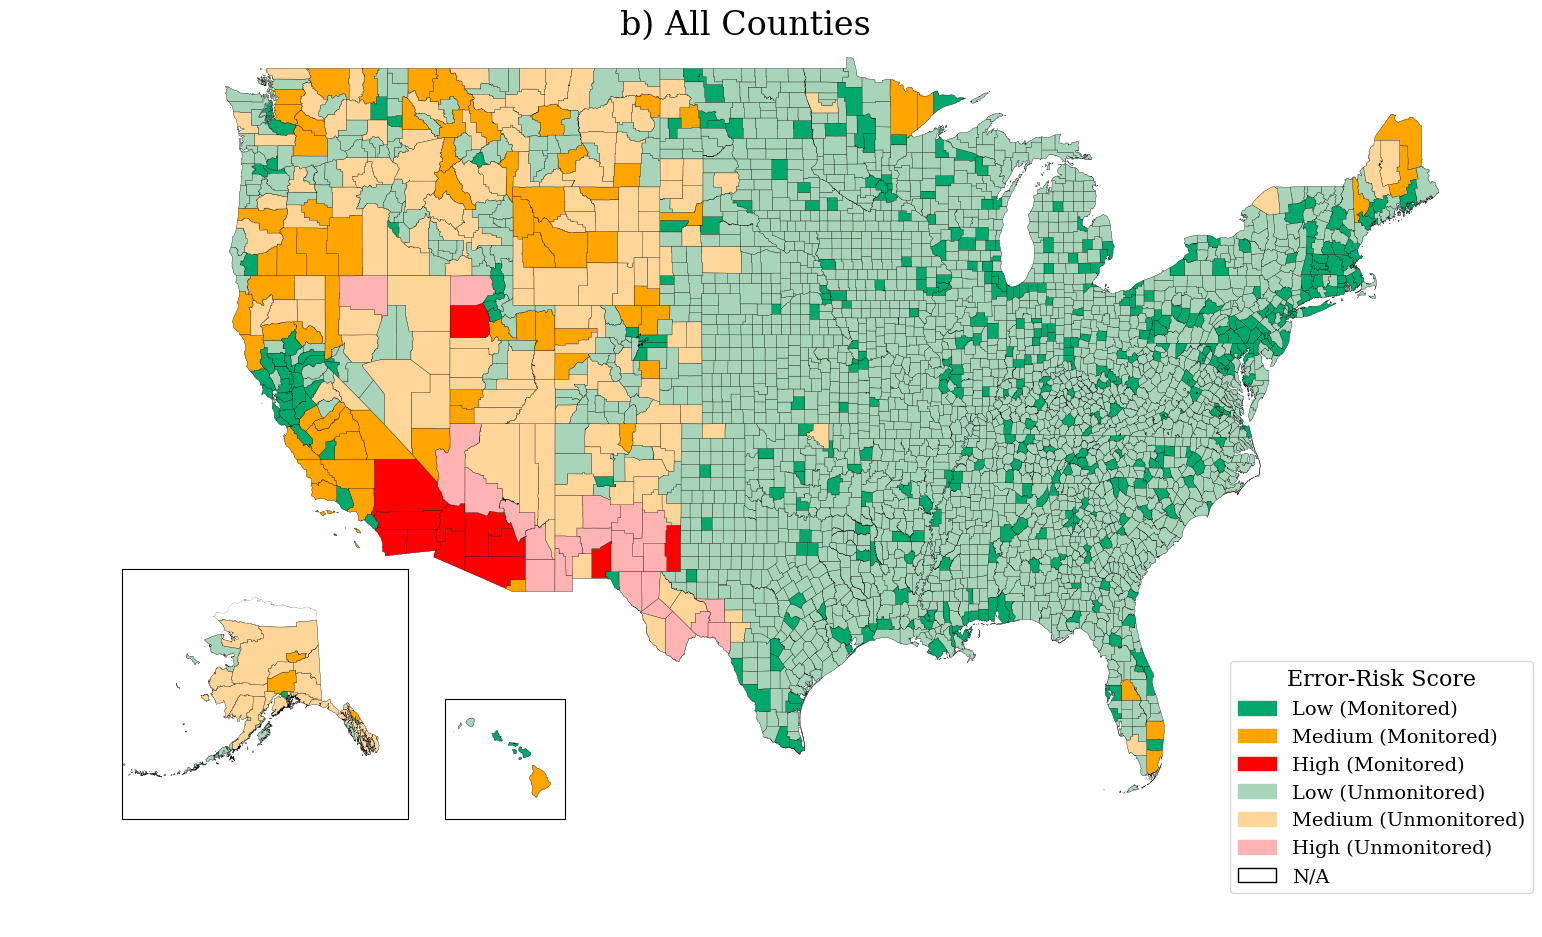

In [27]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd
import matplotlib.patches as mpatches
import pandas as pd

# --- Prepare monitored data ---
gdf_epa = gdf_epa.to_crs("EPSG:4326")  # Monitored counties CRS
data_column_mon = 'risk_score_A'

# Define color mapping for monitored counties
def assign_risk_color_mon(value):
    if pd.isna(value):
        return 'white'
    elif value <= 0.5:
        return '#00A86B'  # Dark green for low risk
    elif value <= 0.75:
        return '#FFA500'  # Orange for medium risk
    else:
        return '#FF0000'  # Red for high risk

gdf_epa['color'] = gdf_epa[data_column_mon].apply(assign_risk_color_mon)

# --- Prepare unmonitored data ---
unmon_df = unmon_df.to_crs("EPSG:4326")
data_column_unmon = 'risk_score_A'

# Define muted color mapping for unmonitored counties
def assign_risk_color_unmon(value):
    if pd.isna(value):
        return 'white'
    elif value <= 0.5:
        return '#A8D5BA'  # Muted green for low risk
    elif value <= 0.75:
        return '#FFD699'  # Muted orange for medium risk
    else:
        return '#FFB3B3'  # Muted red for high risk

unmon_df['color'] = unmon_df[data_column_unmon].apply(assign_risk_color_unmon)

# --- Start plotting ---
fig = plt.figure(figsize=(15, 10))

# Main map (CONUS)
ax_conus = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax_conus.set_extent([-135, -65, 20, 50], crs=ccrs.PlateCarree())
ax_conus.set_frame_on(False)

# Alaska inset
alaska_projection = ccrs.AlbersEqualArea(central_longitude=-150, central_latitude=60)
ax_alaska = fig.add_axes([0.07, 0.14, 0.22, 0.25], projection=alaska_projection)
ax_alaska.set_extent([-180, -126, 50, 72], crs=ccrs.PlateCarree())

# Hawaii inset
ax_hawaii = fig.add_axes([0.28, 0.14, 0.12, 0.12], projection=ccrs.PlateCarree())
ax_hawaii.set_extent([-161, -154, 18, 23], crs=ccrs.PlateCarree())

# --- Plot base maps ---
counties_conus.plot(
    color='white', linewidth=0.1, edgecolor='black', ax=ax_conus
)
counties_conus.plot(
    color='white', linewidth=0.1, edgecolor='black', ax=ax_alaska, transform=ccrs.PlateCarree()
)
counties_conus.plot(
    color='white', linewidth=0.1, edgecolor='black', ax=ax_hawaii
)

# --- Plot monitored counties ---
gdf_epa.plot(
    color=gdf_epa['color'], linewidth=0.2, edgecolor='black', ax=ax_conus
)
gdf_epa.plot(
    color=gdf_epa['color'], linewidth=0.2, edgecolor='black', ax=ax_alaska, transform=ccrs.PlateCarree()
)
gdf_epa.plot(
    color=gdf_epa['color'], linewidth=0.2, edgecolor='black', ax=ax_hawaii
)

# --- Plot unmonitored counties ---
unmon_df.plot(
    color=unmon_df['color'], linewidth=0.2, edgecolor='black', ax=ax_conus
)
unmon_df.plot(
    color=unmon_df['color'], linewidth=0.2, edgecolor='black', ax=ax_alaska, transform=ccrs.PlateCarree()
)
unmon_df.plot(
    color=unmon_df['color'], linewidth=0.2, edgecolor='black', ax=ax_hawaii
)

# --- Custom Legend ---
mon_low = mpatches.Patch(color='#00A86B', label='Low (Monitored)')
mon_med = mpatches.Patch(color='#FFA500', label='Medium (Monitored)')
mon_high = mpatches.Patch(color='#FF0000', label='High (Monitored)')

unmon_low = mpatches.Patch(color='#A8D5BA', label='Low (Unmonitored)')
unmon_med = mpatches.Patch(color='#FFD699', label='Medium (Unmonitored)')
unmon_high = mpatches.Patch(color='#FFB3B3', label='High (Unmonitored)')

na_patch = mpatches.Patch(facecolor="white", edgecolor="black", label="N/A")

plt.legend(
    handles=[mon_low, mon_med, mon_high, unmon_low, unmon_med, unmon_high, na_patch],
    bbox_to_anchor=(6.5, 1.4), loc='upper left',
    title="Error-Risk Score",
    fontsize=14,
    title_fontsize=16
)
fig.suptitle("b) All Counties", fontsize=24, y=0.95)


plt.rcParams["font.family"] = "serif"
plt.tight_layout()
plt.show()


/tmp/ipykernel_557756/3807829233.py:111: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


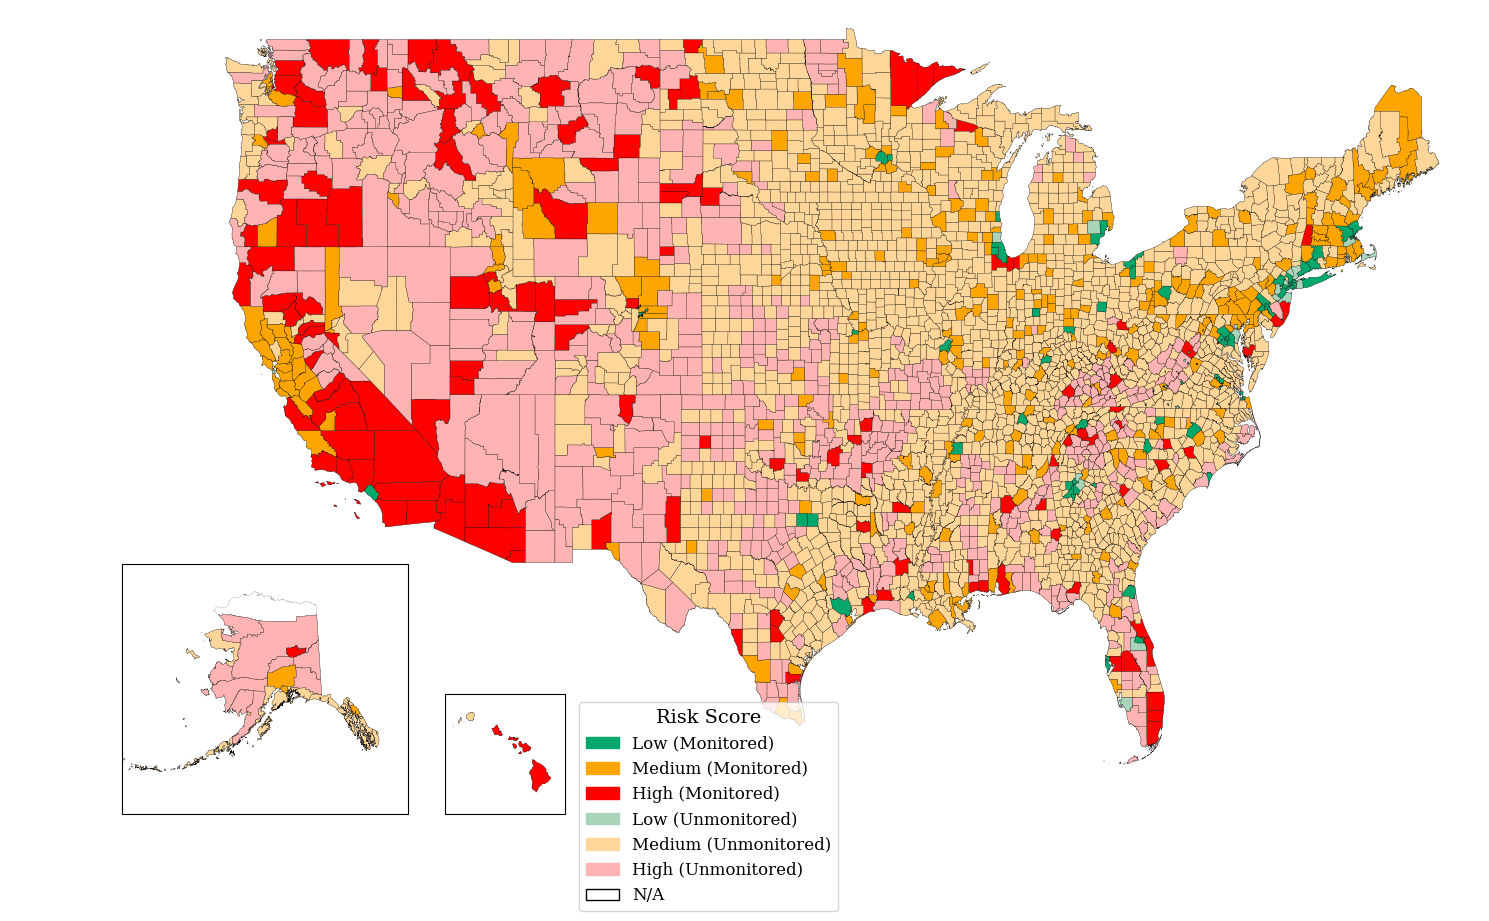

In [17]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd
import matplotlib.patches as mpatches
import pandas as pd

# --- Prepare monitored data ---
gdf_epa = gdf_epa.to_crs("EPSG:4326")  # Monitored counties CRS
data_column_mon = 'risk_score_C_norm'

# Define color mapping for monitored counties
def assign_risk_color_mon(value):
    if pd.isna(value):
        return 'white'
    elif value <= 0.5:
        return '#00A86B'  # Dark green for low risk
    elif value <= 0.75:
        return '#FFA500'  # Orange for medium risk
    else:
        return '#FF0000'  # Red for high risk

gdf_epa['color'] = gdf_epa[data_column_mon].apply(assign_risk_color_mon)

# --- Prepare unmonitored data ---
unmon_df = unmon_df.to_crs("EPSG:4326")
data_column_unmon = 'risk_score_C_norm'

# Define muted color mapping for unmonitored counties
def assign_risk_color_unmon(value):
    if pd.isna(value):
        return 'white'
    elif value <= 0.5:
        return '#A8D5BA'  # Muted green for low risk
    elif value <= 0.75:
        return '#FFD699'  # Muted orange for medium risk
    else:
        return '#FFB3B3'  # Muted red for high risk

unmon_df['color'] = unmon_df[data_column_unmon].apply(assign_risk_color_unmon)

# --- Start plotting ---
fig = plt.figure(figsize=(15, 10))

# Main map (CONUS)
ax_conus = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax_conus.set_extent([-135, -65, 20, 50], crs=ccrs.PlateCarree())
ax_conus.set_frame_on(False)

# Alaska inset
alaska_projection = ccrs.AlbersEqualArea(central_longitude=-150, central_latitude=60)
ax_alaska = fig.add_axes([0.07, 0.14, 0.22, 0.25], projection=alaska_projection)
ax_alaska.set_extent([-180, -126, 50, 72], crs=ccrs.PlateCarree())

# Hawaii inset
ax_hawaii = fig.add_axes([0.28, 0.14, 0.12, 0.12], projection=ccrs.PlateCarree())
ax_hawaii.set_extent([-161, -154, 18, 23], crs=ccrs.PlateCarree())

# --- Plot base maps ---
counties_conus.plot(
    color='white', linewidth=0.1, edgecolor='black', ax=ax_conus
)
counties_conus.plot(
    color='white', linewidth=0.1, edgecolor='black', ax=ax_alaska, transform=ccrs.PlateCarree()
)
counties_conus.plot(
    color='white', linewidth=0.1, edgecolor='black', ax=ax_hawaii
)

# --- Plot monitored counties ---
gdf_epa.plot(
    color=gdf_epa['color'], linewidth=0.2, edgecolor='black', ax=ax_conus
)
gdf_epa.plot(
    color=gdf_epa['color'], linewidth=0.2, edgecolor='black', ax=ax_alaska, transform=ccrs.PlateCarree()
)
gdf_epa.plot(
    color=gdf_epa['color'], linewidth=0.2, edgecolor='black', ax=ax_hawaii
)

# --- Plot unmonitored counties ---
unmon_df.plot(
    color=unmon_df['color'], linewidth=0.2, edgecolor='black', ax=ax_conus
)
unmon_df.plot(
    color=unmon_df['color'], linewidth=0.2, edgecolor='black', ax=ax_alaska, transform=ccrs.PlateCarree()
)
unmon_df.plot(
    color=unmon_df['color'], linewidth=0.2, edgecolor='black', ax=ax_hawaii
)

# --- Custom Legend ---
mon_low = mpatches.Patch(color='#00A86B', label='Low (Monitored)')
mon_med = mpatches.Patch(color='#FFA500', label='Medium (Monitored)')
mon_high = mpatches.Patch(color='#FF0000', label='High (Monitored)')

unmon_low = mpatches.Patch(color='#A8D5BA', label='Low (Unmonitored)')
unmon_med = mpatches.Patch(color='#FFD699', label='Medium (Unmonitored)')
unmon_high = mpatches.Patch(color='#FFB3B3', label='High (Unmonitored)')

na_patch = mpatches.Patch(facecolor="white", edgecolor="black", label="N/A")

plt.legend(
    handles=[mon_low, mon_med, mon_high, unmon_low, unmon_med, unmon_high, na_patch],
    bbox_to_anchor=(1.05, 1), loc='upper left',
    title="Risk Score",
    fontsize=12,
    title_fontsize=14
)

plt.rcParams["font.family"] = "serif"
plt.tight_layout()
plt.show()


/tmp/ipykernel_557756/1639359633.py:111: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


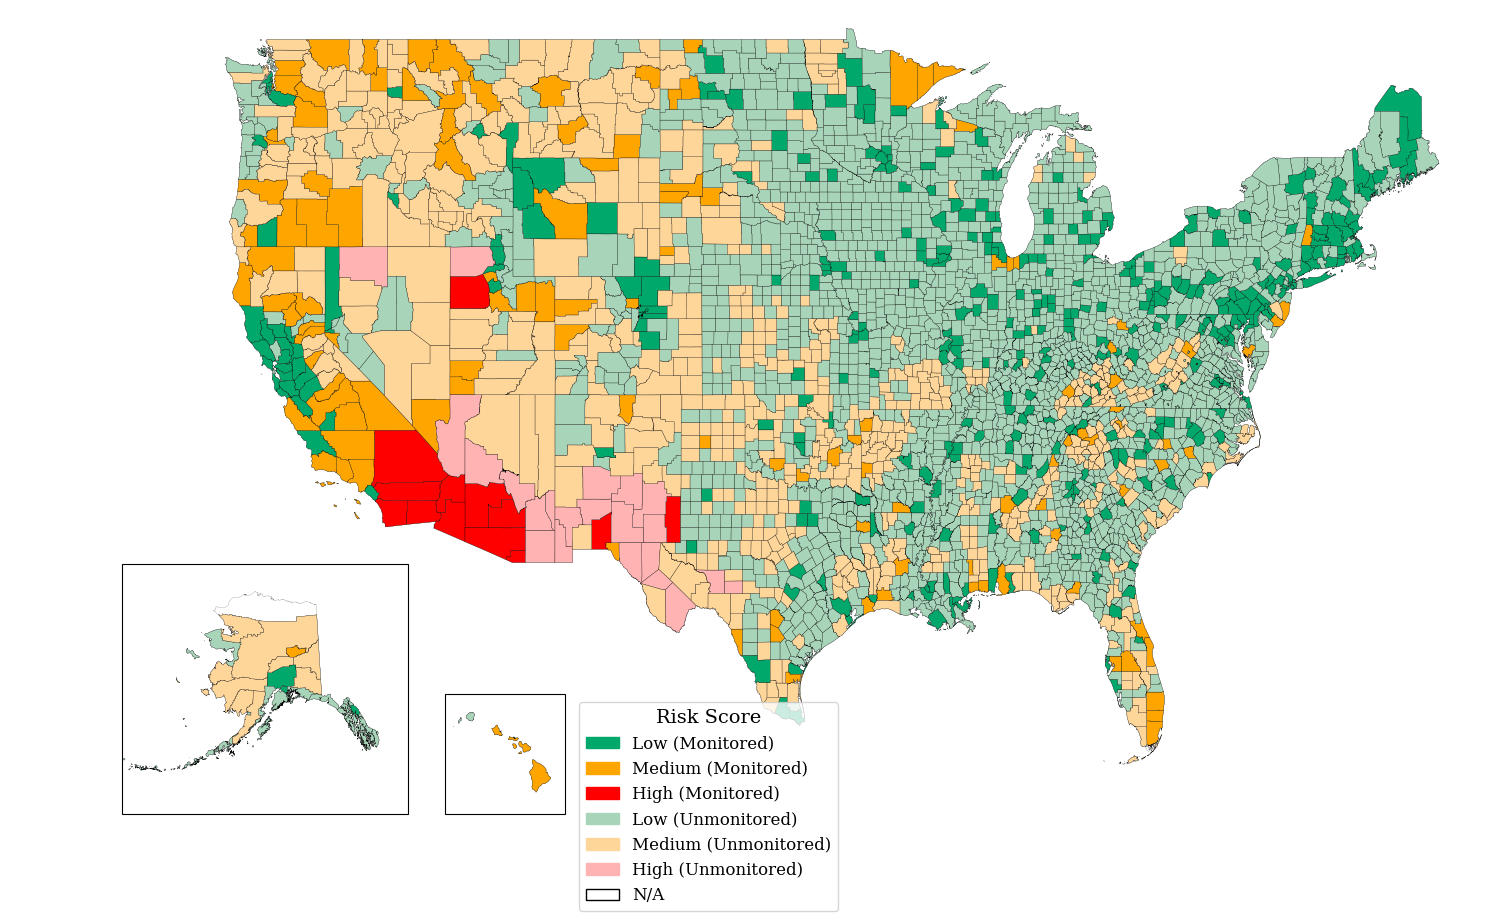

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd
import matplotlib.patches as mpatches
import pandas as pd

# --- Prepare monitored data ---
gdf_epa = gdf_epa.to_crs("EPSG:4326")  # Monitored counties CRS
data_column_mon = 'risk_score_A_norm'

# Define color mapping for monitored counties
def assign_risk_color_mon(value):
    if pd.isna(value):
        return 'white'
    elif value <= 0.5:
        return '#00A86B'  # Dark green for low risk
    elif value <= 0.75:
        return '#FFA500'  # Orange for medium risk
    else:
        return '#FF0000'  # Red for high risk

gdf_epa['color'] = gdf_epa[data_column_mon].apply(assign_risk_color_mon)

# --- Prepare unmonitored data ---
unmon_df = unmon_df.to_crs("EPSG:4326")
data_column_unmon = 'risk_score_A_norm'

# Define muted color mapping for unmonitored counties
def assign_risk_color_unmon(value):
    if pd.isna(value):
        return 'white'
    elif value <= 0.5:
        return '#A8D5BA'  # Muted green for low risk
    elif value <= 0.75:
        return '#FFD699'  # Muted orange for medium risk
    else:
        return '#FFB3B3'  # Muted red for high risk

unmon_df['color'] = unmon_df[data_column_unmon].apply(assign_risk_color_unmon)

# --- Start plotting ---
fig = plt.figure(figsize=(15, 10))

# Main map (CONUS)
ax_conus = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax_conus.set_extent([-135, -65, 20, 50], crs=ccrs.PlateCarree())
ax_conus.set_frame_on(False)

# Alaska inset
alaska_projection = ccrs.AlbersEqualArea(central_longitude=-150, central_latitude=60)
ax_alaska = fig.add_axes([0.07, 0.14, 0.22, 0.25], projection=alaska_projection)
ax_alaska.set_extent([-180, -126, 50, 72], crs=ccrs.PlateCarree())

# Hawaii inset
ax_hawaii = fig.add_axes([0.28, 0.14, 0.12, 0.12], projection=ccrs.PlateCarree())
ax_hawaii.set_extent([-161, -154, 18, 23], crs=ccrs.PlateCarree())

# --- Plot base maps ---
counties_conus.plot(
    color='white', linewidth=0.1, edgecolor='black', ax=ax_conus
)
counties_conus.plot(
    color='white', linewidth=0.1, edgecolor='black', ax=ax_alaska, transform=ccrs.PlateCarree()
)
counties_conus.plot(
    color='white', linewidth=0.1, edgecolor='black', ax=ax_hawaii
)

# --- Plot monitored counties ---
gdf_epa.plot(
    color=gdf_epa['color'], linewidth=0.2, edgecolor='black', ax=ax_conus
)
gdf_epa.plot(
    color=gdf_epa['color'], linewidth=0.2, edgecolor='black', ax=ax_alaska, transform=ccrs.PlateCarree()
)
gdf_epa.plot(
    color=gdf_epa['color'], linewidth=0.2, edgecolor='black', ax=ax_hawaii
)

# --- Plot unmonitored counties ---
unmon_df.plot(
    color=unmon_df['color'], linewidth=0.2, edgecolor='black', ax=ax_conus
)
unmon_df.plot(
    color=unmon_df['color'], linewidth=0.2, edgecolor='black', ax=ax_alaska, transform=ccrs.PlateCarree()
)
unmon_df.plot(
    color=unmon_df['color'], linewidth=0.2, edgecolor='black', ax=ax_hawaii
)

# --- Custom Legend ---
mon_low = mpatches.Patch(color='#00A86B', label='Low (Monitored)')
mon_med = mpatches.Patch(color='#FFA500', label='Medium (Monitored)')
mon_high = mpatches.Patch(color='#FF0000', label='High (Monitored)')

unmon_low = mpatches.Patch(color='#A8D5BA', label='Low (Unmonitored)')
unmon_med = mpatches.Patch(color='#FFD699', label='Medium (Unmonitored)')
unmon_high = mpatches.Patch(color='#FFB3B3', label='High (Unmonitored)')

na_patch = mpatches.Patch(facecolor="white", edgecolor="black", label="N/A")

plt.legend(
    handles=[mon_low, mon_med, mon_high, unmon_low, unmon_med, unmon_high, na_patch],
    bbox_to_anchor=(6.05, 1), loc='upper left',
    title="Risk Score",
    fontsize=12,
    title_fontsize=14
)

plt.rcParams["font.family"] = "serif"
plt.tight_layout()
plt.show()
